In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 400
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        D = np.linalg.norm(Uto-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        if isinstance(t, float):
             rho_vector[0][int(round(t,0))+r] = pt[0][0]
             rho_vector[1][int(round(t,0))+r] = pt[0][1]
             rho_vector[2][int(round(t,0))+r] = pt[1][0]
             rho_vector[3][int(round(t,0))+r] = pt[1][1]
             r += 1
        else:
            rho_vector[0][t] = pt[0][0]
            rho_vector[1][t] = pt[0][1]
            rho_vector[2][t] = pt[1][0]
            rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        while 1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1:
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            fid_vector[-1] = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores[-1] = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            aas[-1] = ((u[0],u[1],u[2]))
        
        resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        u[0] = resultado_algoritmo_genetico[0]
        u[1] = resultado_algoritmo_genetico[1]
        u[2] = resultado_algoritmo_genetico[2]
        aas.append((u[0],u[1],u[2]))
        t += 1
        Ut = Uto

    print(f"O rho gerado foi: {pt}") 
    print(f"A matriz de evolução Ut gerada foi: {Ut}")
    print(f"Portanto, a distância gerada foi: {D}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
O rho gerado foi: [[np.float64(0.9970443856026086), np.complex128(-0.008258877911301582+0.13211540753825857j)], [np.complex128(-0.008258877911301582-0.13211540753825857j), np.float64(0.002955614397391504)]]
A matriz de evolução Ut gerada foi: [[-0.01651776 -0.12742338  1.00599791]
 [-0.26423082 -0.97797928 -0.10047885]
 [ 0.99408877 -0.26875256 -0.02367092]]
Portanto, a distância gerada foi: 0.16976755569274313
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.5000253697869187361-0.00014755444956812647515j'), np.clongdouble('0.54761697149120569614-0.00020980665508269109452j'), np.clongdouble('0.57498943382984028956+1.2221355879470504733e-12j'), np.clongdouble('0.5750444620275136441+2.1916851009295506126e-05j'), np.clongdouble('0.6509048141028774717+0.00013683075493086060661j'), np.clongdouble('0.7029811962760868806-0.00030253762357596501093j'), np.clongdouble('0.703234293102576095+3.3355778688004658083e-05j'), np.clongdouble('0.7543328

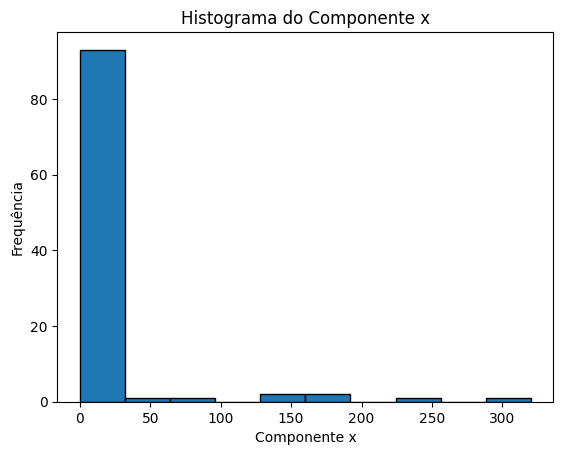

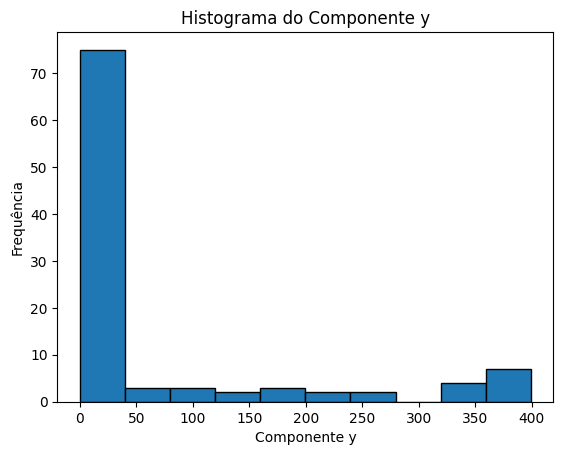

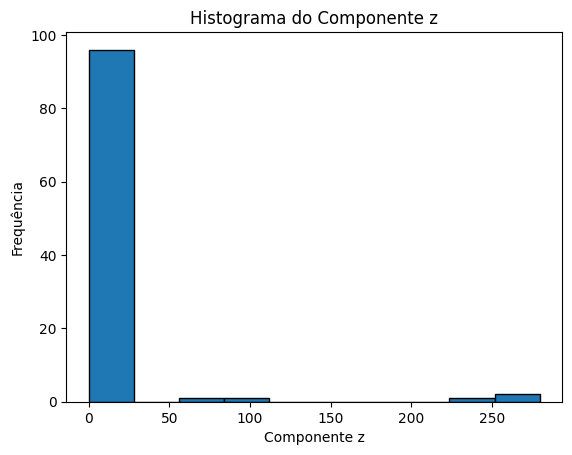

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9995646911884588
Estados: (0.9970842599540302+9.445043902959126e-05j)
Distância: 0.16976755569274313
 
Começará a função principal


/tmp/ipykernel_2099/116918231.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  f = -a*SA-h*(SB/SA)


O rho gerado foi: [[np.float64(0.9790187145705689), np.complex128(9.803957345650067e-05-0.1857744839413688j)], [np.complex128(9.803957345650067e-05+0.1857744839413688j), np.float64(0.020981285429431173)]]
A matriz de evolução Ut gerada foi: [[ 1.96079147e-04 -7.10528612e-03  1.04828543e+00]
 [ 3.71548968e-01 -9.56922718e-01  7.77295555e-03]
 [ 9.58037429e-01  3.65028138e-01 -2.95240387e-03]]
Portanto, a distância gerada foi: 0.056660668039962614
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.4188729946839251474-0.00014353679893486077349j'), np.clongdouble('0.41893059822052317953+9.2828265373171591254e-05j'), np.clongdouble('0.41829085894459049682+6.072377978934682653e-05j'), np.clongdouble('0.5096380012409266147-0.00017770716236706043516j'), np.clongdouble('0.50986543761584955523-5.2758849256133692457e-05j'), np.clongdouble('0.48648688953428240203+0.00012279501339748164671j'), np.clongdouble('0.36950542276510734736+

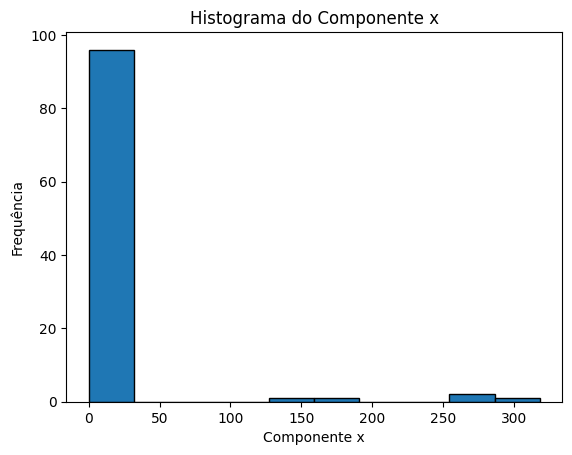

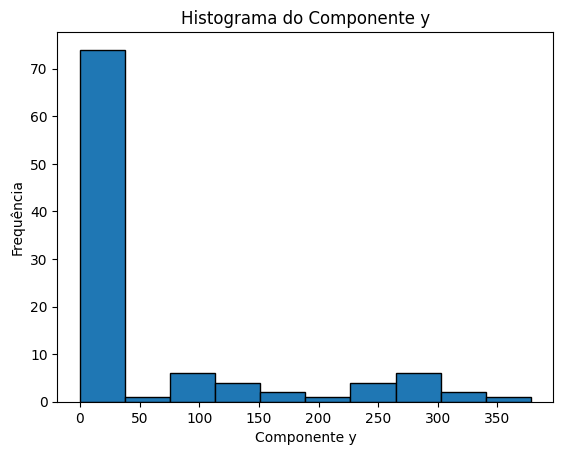

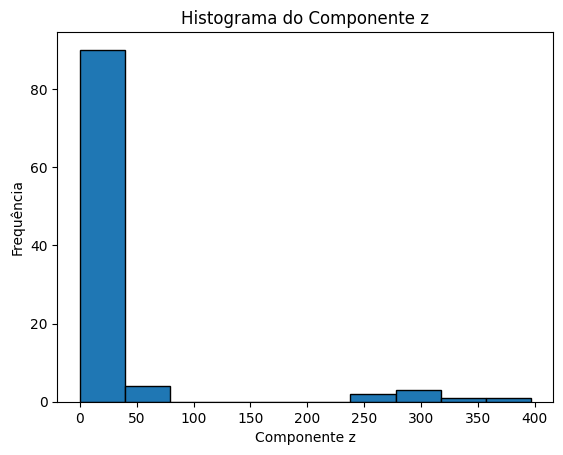

Terminou o histograma
Valores de média na iteração 2:
Portas: 0.9991439023022972
Estados: (0.9880735655694796-1.6629423879293952e-05j)
Distância: 0.11321411186635287
 
Começará a função principal
O rho gerado foi: [[np.float64(0.9940460563283848), np.complex128(0.07126022787488412-0.04508088929727561j)], [np.complex128(0.07126022787488412+0.04508088929727561j), np.float64(0.005953943671615225)]]
A matriz de evolução Ut gerada foi: [[ 0.14252046  0.0062295   0.99805309]
 [ 0.09016178 -1.00557457 -0.00668951]
 [ 0.98809211  0.08651697 -0.14005893]]
Portanto, a distância gerada foi: 0.05580313604733524
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.4447257489921878932+0j'), np.clongdouble('0.46174049978166920502-3.388819084272514168e-05j'), np.clongdouble('0.48263693209600485237+0.00013385650737783207858j'), np.clongdouble('0.508426591168355663+4.8517853409139619406e-07j'), np.clongdouble('0.5092756102260329407+6.859091212974233003e-05j'), np.clongdouble('0.50921

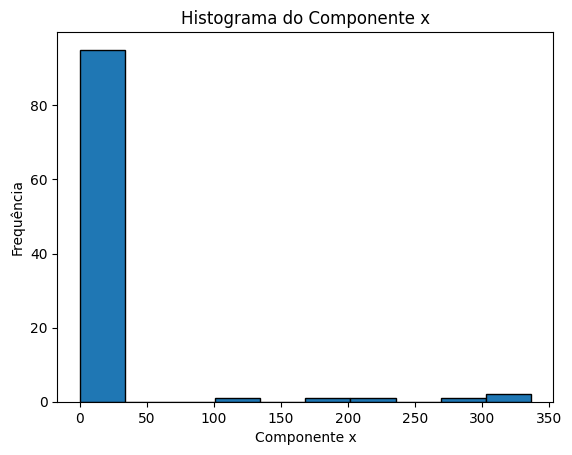

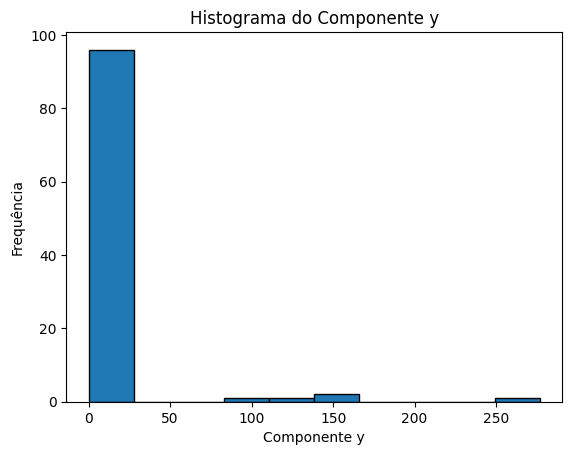

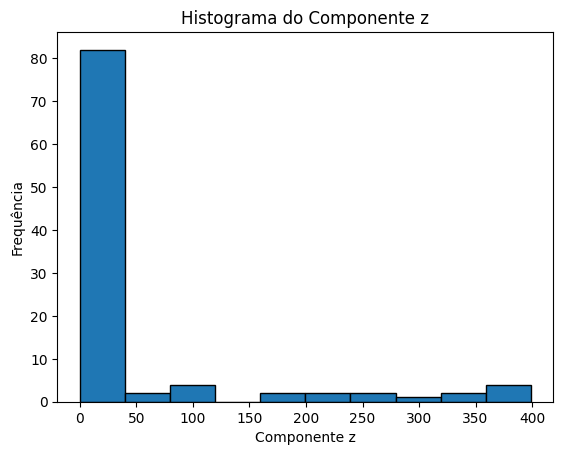

Terminou o histograma
Valores de média na iteração 3:
Portas: 0.9991412092226778
Estados: (0.9900865351928988-9.183007486704783e-06j)
Distância: 0.09407711992668033
 
Começará a função principal
O rho gerado foi: [[np.float64(0.9840388943965956), np.complex128(0.002280532776426896+0.19381421543867644j)], [np.complex128(0.002280532776426896-0.19381421543867644j), np.float64(0.015961105603404413)]]
A matriz de evolução Ut gerada foi: [[ 4.56106555e-03 -1.46380230e-02  1.04621864e+00]
 [-3.87628431e-01 -9.43753948e-01  6.50679919e-04]
 [ 9.68077789e-01 -3.59617269e-01 -1.41474551e-03]]
Portanto, a distância gerada foi: 0.2861366890348022
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465197472881696+2.3961174915074870941e-21j'), np.clongdouble('0.41731420362717729926+0.00019432356027739173564j'), np.clongdouble('0.42334887876317836168-4.4811517194857736916e-05j'), np.clongdouble('0.4482471215817791033+0.0001355167802299215075j'), np.clongdouble('0.5216969280

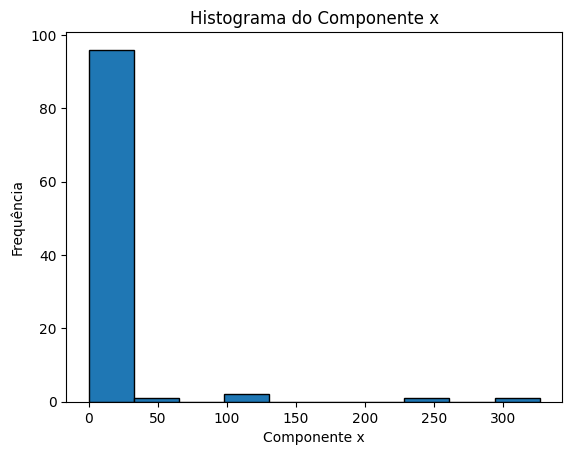

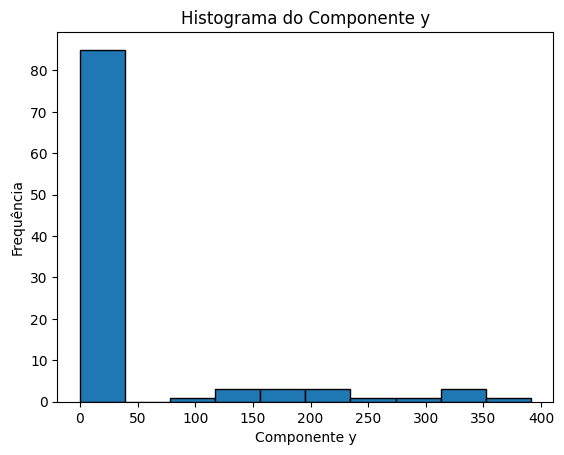

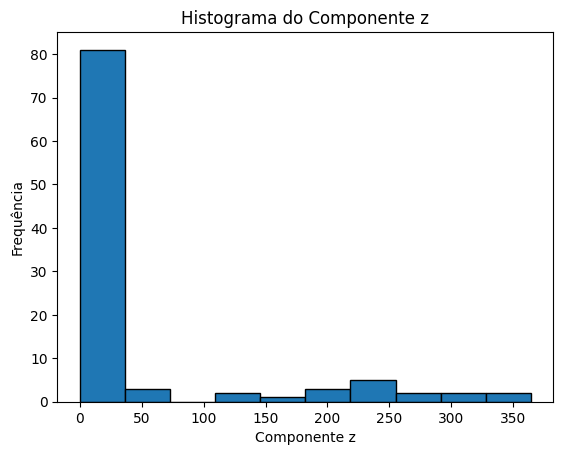

Terminou o histograma
Valores de média na iteração 4:
Portas: 0.9983621460867166
Estados: (0.988609078554631-2.3945894496220836e-05j)
Distância: 0.14209201220371082
 
Começará a função principal
O rho gerado foi: [[np.float64(0.9966058113648117), np.complex128(0.03791460674244138-0.07541186387836742j)], [np.complex128(0.03791460674244138+0.07541186387836742j), np.float64(0.0033941886351882555)]]
A matriz de evolução Ut gerada foi: [[ 0.07582921  0.00802307  1.00328009]
 [ 0.15082373 -0.9952803  -0.00839945]
 [ 0.99321162  0.14502049 -0.07232262]]
Portanto, a distância gerada foi: 0.05497340632069549
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.49994601921776180288+0.00014448020764347167301j'), np.clongdouble('0.50007884283782646123+1.8728360575748971527e-16j'), np.clongdouble('0.49995057813055872174-6.884759956291336188e-15j'), np.clongdouble('0.49995302186519695886-1.4448622789795483045e-05j'), np.clongdouble('0.

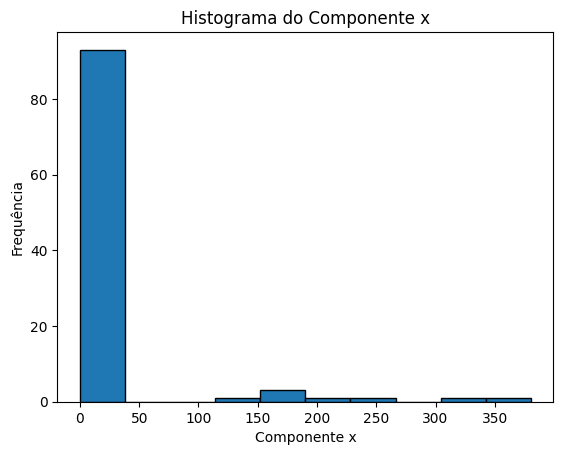

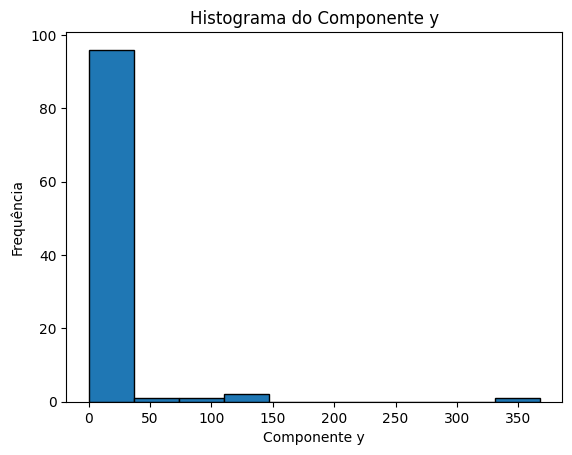

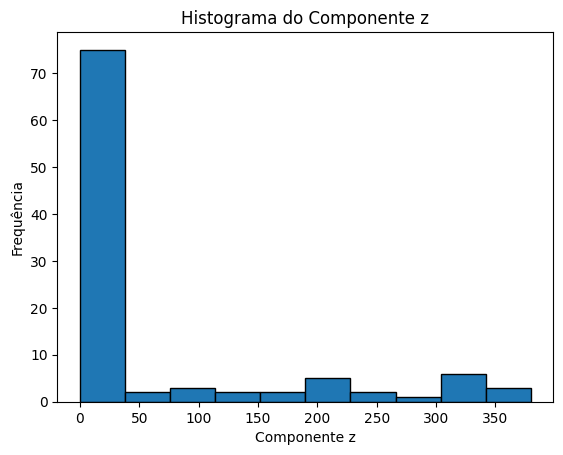

Terminou o histograma
Valores de média na iteração 5:
Portas: 0.9985100042681324
Estados: (0.9902115388260472-3.947402110350363e-06j)
Distância: 0.12466829102710775
 
Começará a função principal
O rho gerado foi: [[np.float64(0.9987876308387451), np.complex128(0.0658233647082649+0.003710655561284105j)], [np.complex128(0.0658233647082649-0.003710655561284105j), np.float64(0.0012123691612548892)]]
A matriz de evolução Ut gerada foi: [[ 0.13164673 -0.06597788  0.99393748]
 [-0.00742131 -1.00187128 -0.07101892]
 [ 0.99757526  0.00580388 -0.13432747]]
Portanto, a distância gerada foi: 0.036416391330246635
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.4944541706337817166-2.5399358775682238221e-06j'), np.clongdouble('0.4891634301216328703-0.00018838953235192830898j'), np.clongdouble('0.5575646309278584923-0.0003286969615657374605j'), np.clongdouble('0.55766164316165358174-0.00022301195055258530606j'), np.clongdouble('0.55

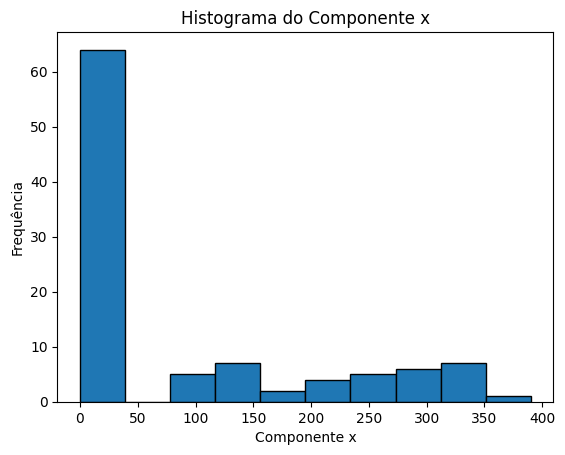

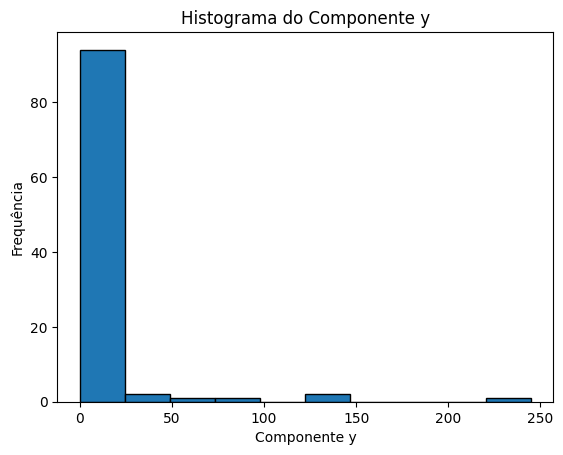

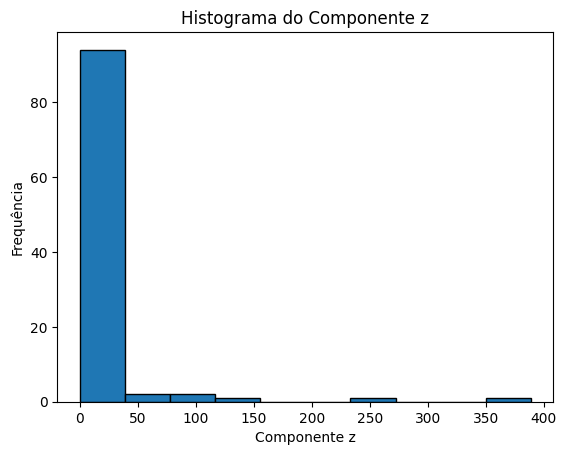

Terminou o histograma
Valores de média na iteração 6:
Portas: 0.9986475355889025
Estados: (0.9916532469548471-3.163407013460697e-06j)
Distância: 0.1099596410776309
 
Começará a função principal
O rho gerado foi: [[np.float64(0.9923571607049115), np.complex128(-0.103316349506749-0.0008274295860987291j)], [np.complex128(-0.103316349506749+0.0008274295860987291j), np.float64(0.007642839295088466)]]
A matriz de evolução Ut gerada foi: [[-2.06632699e-01 -8.13438688e-04  9.87158977e-01]
 [ 1.65485917e-03 -1.01385280e+00  1.49002483e-03]
 [ 9.84714321e-01 -1.59290412e-03  1.96933787e-01]]
Portanto, a distância gerada foi: 0.08207859019649598
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.5001450718161777205-6.4614224473461873625e-06j'), np.clongdouble('0.50015481654634507097-0.00025000971151240474346j'), np.clongdouble('0.50053576538332118665+5.9453390249969944405e-05j'), np.clongdouble('0.5006885888425346065+3.564335734760838432e-05j'), np.clongdouble('0.50054914393

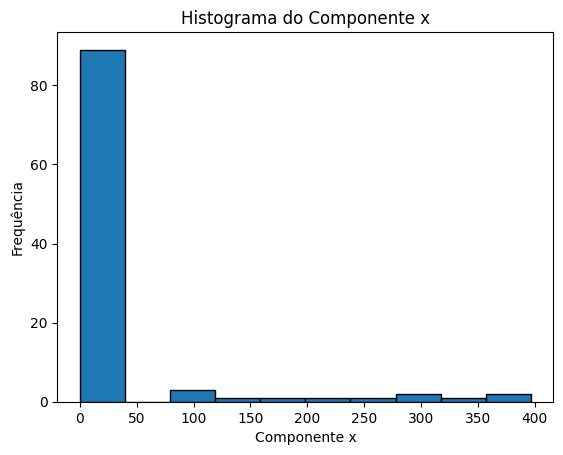

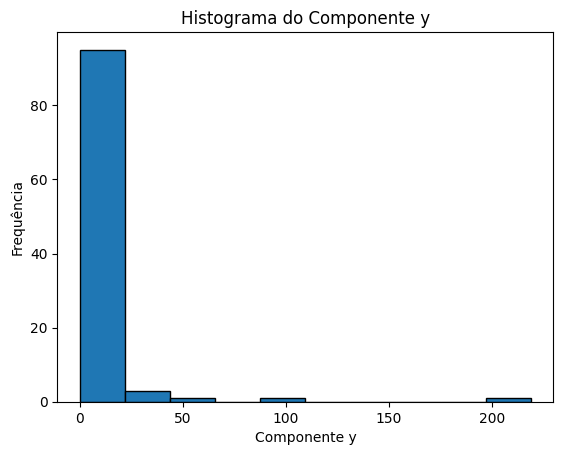

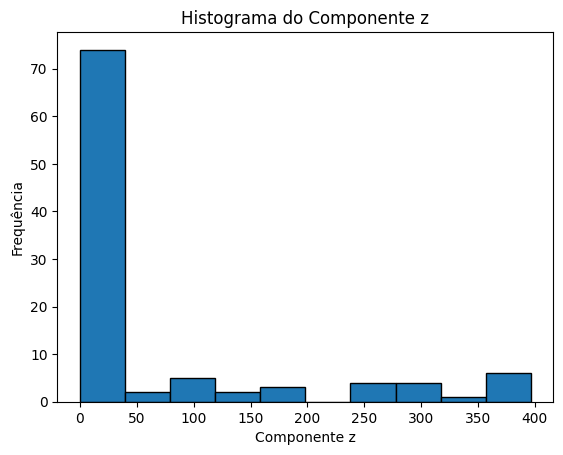

Terminou o histograma
Valores de média na iteração 7:
Portas: 0.9984608767312954
Estados: (0.9917700137832111-1.7864368756706112e-06j)
Distância: 0.10597663380889734
 
Começará a função principal
O rho gerado foi: [[np.float64(0.9989855436945195), np.complex128(0.03298852218332614+0.001458268213541653j)], [np.complex128(0.03298852218332614-0.001458268213541653j), np.float64(0.0010144563054804712)]]
A matriz de evolução Ut gerada foi: [[ 0.06597704 -0.09612969  0.99758529]
 [-0.00291654 -0.99998862 -0.09522207]
 [ 0.99797109  0.00313117 -0.06536785]]
Portanto, a distância gerada foi: 0.026962344738800253
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.49956258915890571105+0.00020574289386290997709j'), np.clongdouble('0.49966567142752588116-6.140566932266629485e-05j'), np.clongdouble('0.5910671970779823358+7.197201069503138965e-13j'), np.clongdouble('0.6677953872222825815-0.00031438262436223765123j'), np.clongdouble('0

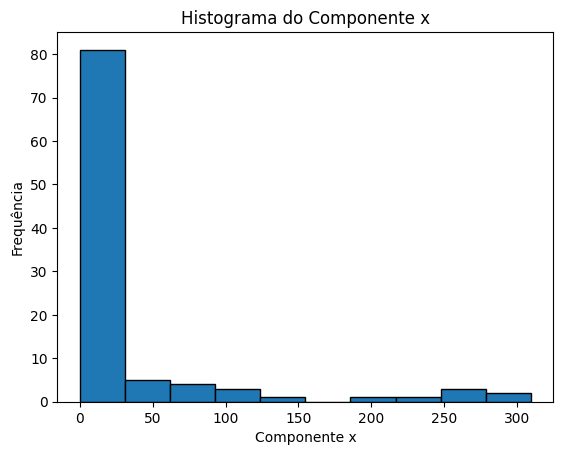

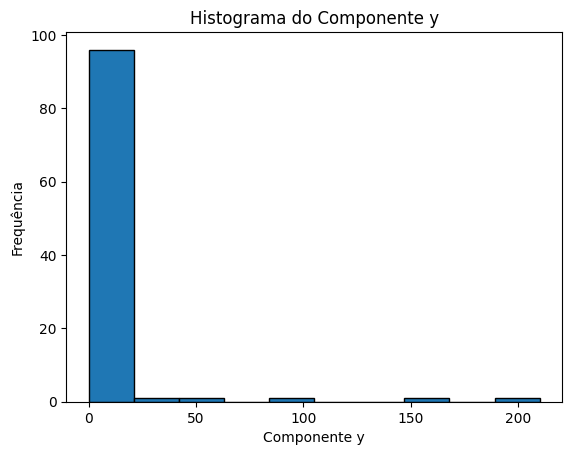

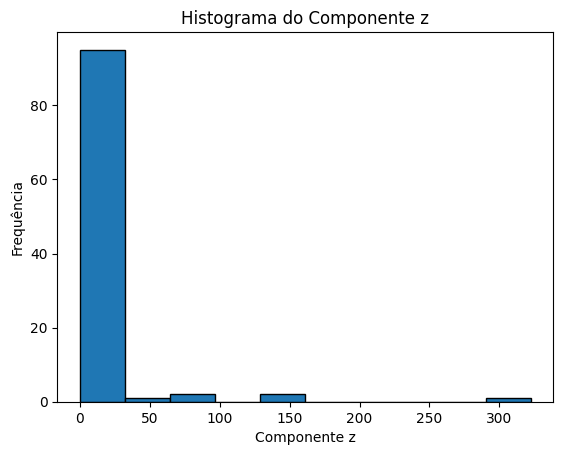

Terminou o histograma
Valores de média na iteração 8:
Portas: 0.9985630808578733
Estados: (0.9926719809155861-4.259167680455061e-06j)
Distância: 0.0960998476751352
 
Começará a função principal
O rho gerado foi: [[np.float64(0.9947505147865858), np.complex128(0.10347888006860592+0.000313572858006969j)], [np.complex128(0.10347888006860592-0.000313572858006969j), np.float64(0.005249485213414173)]]
A matriz de evolução Ut gerada foi: [[ 2.06957760e-01  8.83925685e-03  9.81851586e-01]
 [-6.27145716e-04 -1.01218401e+00  2.59535515e-03]
 [ 9.89501030e-01 -2.35279249e-04 -2.12307690e-01]]
Portanto, a distância gerada foi: 0.0885794301063653
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.49186168100206059518-0.0001836505920533689248j'), np.clongdouble('0.4915513614881833379-0.00018846286211755993581j'), np.clongdouble('0.49135510641513150618+7.472678489026649507e-06j'), np.clongdouble('0.4895908074487220199-2.08969435692793

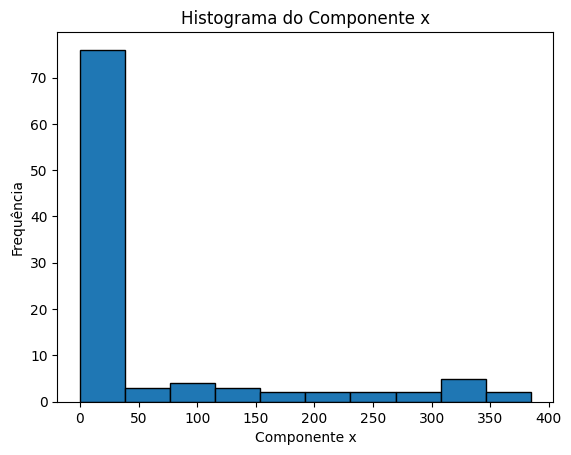

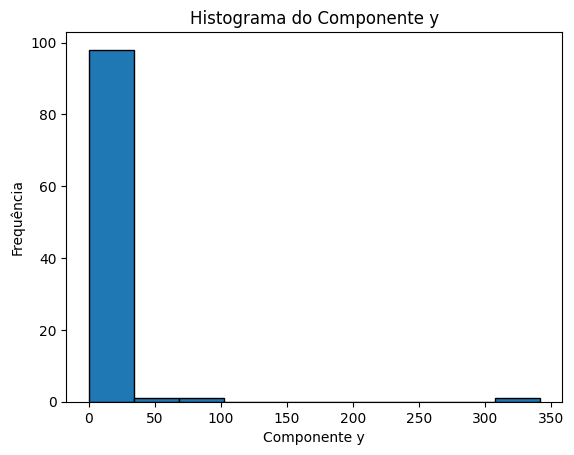

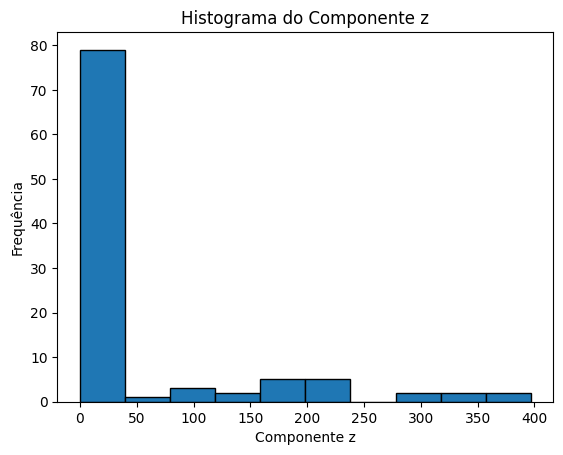

Terminou o histograma
Valores de média na iteração 9:
Portas: 0.998325919117728
Estados: (0.9929051088796794+2.7105799411900262e-06j)
Distância: 0.09526424572304965
 
Começará a função principal
O rho gerado foi: [[np.float64(0.9949663279783446), np.complex128(-0.0014059847466233832-0.07012780580578513j)], [np.complex128(-0.0014059847466233832+0.07012780580578513j), np.float64(0.005033672021655389)]]
A matriz de evolução Ut gerada foi: [[-2.81196949e-03  1.31549408e-03  1.00751092e+00]
 [ 1.40255612e-01 -9.97081496e-01  2.11792854e-03]
 [ 9.89932656e-01  1.37292582e-01 -9.80674154e-04]]
Portanto, a distância gerada foi: 0.03870225779699716
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.49858343350884712353-5.1851881841249453852e-17j'), np.clongdouble('0.49830501542155145346+1.1408695014453423129e-15j'), np.clongdouble('0.49817316929313437948-3.5284118398427051037e-08j'), np.clongdouble('0.4980632714127648935+2.51947

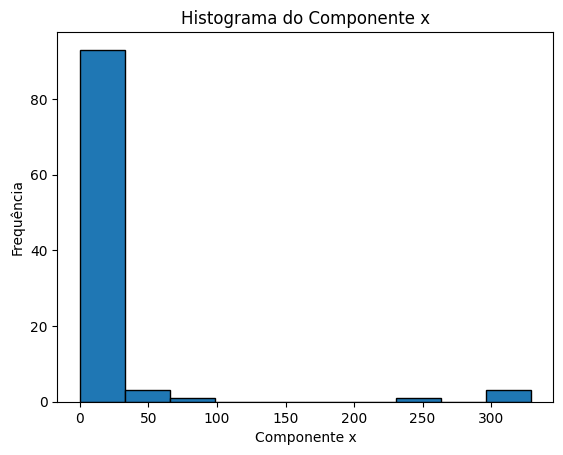

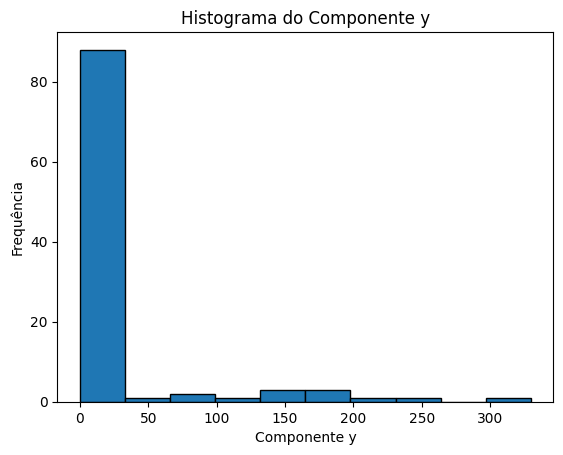

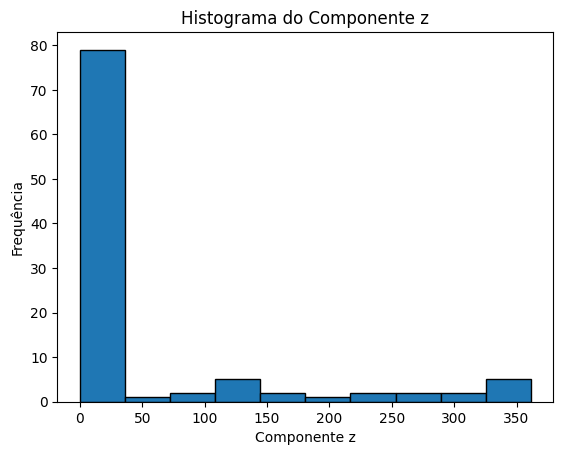

Terminou o histograma
Valores de média na iteração 10:
Portas: 0.998451100858585
Estados: (0.9931144290241298-7.704368620410426e-07j)
Distância: 0.08960804693044441
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

for i in range(1,11):
    print(f"Começará a função principal")
    fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
    print(f"Terminou a função principal")
    print(f"Veja o log: (Dos estados)")
    print(fid_vector)
    print(f"Veja o log: (Das portas)")
    print(fid_autores)
    
    portas.append(fid_autores[-1])
    estados.append(fid_vector[-1])
    distancia.append(distance_vector[-1])
    
    print(f"Começou o histograma")
    histograma(0, a)
    histograma(1, a)
    histograma(2, a)
    print(f"Terminou o histograma")
    
    print(f"Valores de média na iteração {i}:")
    print(f"Portas: {sum(portas)/i}")
    print(f"Estados: {sum(estados)/i}")
    print(f"Distância: {sum(distancia)/i}")
    print(" ")

In [22]:
fid_vector

[np.clongdouble('0.50014465186685759925+0j'),
 np.clongdouble('0.49858343350884712353-5.1851881841249453852e-17j'),
 np.clongdouble('0.49830501542155145346+1.1408695014453423129e-15j'),
 np.clongdouble('0.49817316929313437948-3.5284118398427051037e-08j'),
 np.clongdouble('0.4980632714127648935+2.5194739414129590172e-05j'),
 np.clongdouble('0.5745886789013250957+0.00016907822408880916617j'),
 np.clongdouble('0.57456846219411712945+0.00013488376940897957803j'),
 np.clongdouble('0.574569687096410695+0.00024977007681224786782j'),
 np.clongdouble('0.57490738557656703424-2.1388485226520781166e-12j'),
 np.clongdouble('0.74638924358914365565-0.00012930137363161257695j'),
 np.clongdouble('0.87926428949583835957-1.6263085819232763557e-05j'),
 np.clongdouble('0.8790763196748125886+0.00031387251520425353078j'),
 np.clongdouble('0.8792953261326172476-8.4304650016488963196e-05j'),
 np.clongdouble('0.87927251953880352075+9.348400846774259785e-14j'),
 np.clongdouble('0.8790176675173410206-0.0002918441

In [23]:
fid_autores

[np.float64(0.3331815880616465),
 np.float64(0.3321573829341022),
 np.float64(0.3321524646678986),
 np.float64(0.3265534568057312),
 np.float64(0.29985322488647964),
 np.float64(0.266219238567686),
 np.float64(0.24984124990106424),
 np.float64(0.266101801720184),
 np.float64(0.2662637057691009),
 np.float64(0.3399051640653623),
 np.float64(0.45069738719114266),
 np.float64(0.4506847343422691),
 np.float64(0.45067208190432934),
 np.float64(0.6173302481700026),
 np.float64(0.6173329262754222),
 np.float64(0.7441731587612809),
 np.float64(0.748700286563562),
 np.float64(0.7491394849019942),
 np.float64(0.9013930169010176),
 np.float64(0.9516837036365501),
 np.float64(0.9546338444091372),
 np.float64(0.9546093395302307),
 np.float64(0.9545846257152281),
 np.float64(0.954789050412623),
 np.float64(0.9548278186840555),
 np.float64(0.975513425348428),
 np.float64(0.992782788364026),
 np.float64(0.9927860199968229),
 np.float64(0.9927694645347344),
 np.float64(0.9927432646042477),
 np.float64(

In [24]:
rho_vector

array([[0.5       +0.00000000e+000j, 0.49857163+0.00000000e+000j,
        0.4981603 +0.00000000e+000j, ..., 0.        +0.00000000e+000j,
        0.        +0.00000000e+000j, 0.        +0.00000000e+000j],
       [0.499995  -3.43550630e-199j, 0.49998848-1.73712912e-005j,
        0.49998214+1.82052796e-005j, ..., 0.        +0.00000000e+000j,
        0.        +0.00000000e+000j, 0.        +0.00000000e+000j],
       [0.499995  +3.43550630e-199j, 0.49998848+1.73712912e-005j,
        0.49998214-1.82052796e-005j, ..., 0.        +0.00000000e+000j,
        0.        +0.00000000e+000j, 0.        +0.00000000e+000j],
       [0.5       +0.00000000e+000j, 0.50142837+0.00000000e+000j,
        0.5018397 +0.00000000e+000j, ..., 0.        +0.00000000e+000j,
        0.        +0.00000000e+000j, 0.        +0.00000000e+000j]])

In [25]:
distance_vector

[np.float64(7.998178298357677),
 np.float64(7.985841398358984),
 np.float64(7.9857825240922145),
 np.float64(7.916980724628113),
 np.float64(7.547415894599511),
 np.float64(6.884727231372379),
 np.float64(6.024698543084451),
 np.float64(5.113422833380818),
 np.float64(5.1087797999261815),
 np.float64(3.917636903818209),
 np.float64(2.8917140062524513),
 np.float64(2.8916803885264546),
 np.float64(2.891646772257245),
 np.float64(1.7964096496689879),
 np.float64(1.7962763794069911),
 np.float64(1.1249094981962413),
 np.float64(1.10254541691624),
 np.float64(1.1002795349396182),
 np.float64(0.4033493416620505),
 np.float64(0.23423458911399866),
 np.float64(0.22456827905910356),
 np.float64(0.22456124859494378),
 np.float64(0.22455508608570543),
 np.float64(0.22374920599647954),
 np.float64(0.22348063039659363),
 np.float64(0.14361241570814715),
 np.float64(0.07361812049369354),
 np.float64(0.07349733863935687),
 np.float64(0.031652294157626965),
 np.float64(0.07345398583204345),
 np.float

In [26]:
fx_vector

[np.float64(41.49666090848281),
 np.float64(124.10376287855583),
 np.float64(-0.05692845901453533),
 np.float64(260.35692157961535),
 np.float64(-0.010265347541451067),
 400,
 np.float64(-0.0033316934349770563),
 np.float64(-0.0022272900651132523),
 np.float64(-0.002217601569618598),
 400,
 400,
 np.float64(-3.7959042905128445e-05),
 np.float64(-3.7886564288280724e-05),
 np.float64(0.0006487871728367792),
 np.float64(0.000645606768048672),
 np.float64(0.0009828427280131238),
 np.float64(0.0009847651789928232),
 np.float64(0.9216071881388279),
 np.float64(332.5545847714777),
 np.float64(0.0006758127700635909),
 np.float64(0.000868683541926064),
 np.float64(0.000875162188627108),
 np.float64(0.0008755732594132241),
 np.float64(0.0008815001623812526),
 np.float64(0.0008795780564521793),
 np.float64(0.000450511073679776),
 np.float64(65.79337623356587),
 np.float64(0.17143545088458764),
 np.float64(54.31190752153354),
 np.float64(0.0003566585729735655),
 np.float64(0.018873877191828876),
 

In [27]:
fy_vector

[np.float64(3.31211726543398e-194),
 np.float64(0.8947548579307445),
 np.float64(0.7964787719287348),
 np.float64(0.17490542680346352),
 np.float64(-0.4117189919492056),
 np.float64(-0.114989955213332),
 np.float64(-0.02669819819855128),
 np.float64(-0.006537099420816212),
 np.float64(-0.006430156694501705),
 np.float64(-0.00357236241741533),
 np.float64(-0.00043780990065237456),
 np.float64(-0.0004127724335315593),
 np.float64(-0.0004119854660185322),
 np.float64(0.0030900802871951616),
 np.float64(0.3496856023610987),
 np.float64(0.002692498685819943),
 np.float64(0.002595218036219153),
 np.float64(0.00259488064674267),
 np.float64(0.0017830393655663748),
 np.float64(0.0006755020006339825),
 np.float64(0.0009020086155616916),
 np.float64(0.000936956743685362),
 np.float64(0.0009373325506719546),
 np.float64(0.0009204996511508189),
 np.float64(0.30886717337668007),
 np.float64(53.33015602148925),
 np.float64(0.0006592074285827122),
 np.float64(0.00067952967205476),
 np.float64(7.31560

In [28]:
fz_vector

[np.float64(0.0),
 np.float64(-0.06976071159605413),
 np.float64(-0.07107342499558708),
 np.float64(-0.028174266595484197),
 400,
 np.float64(-0.005682218213036552),
 400,
 400,
 np.float64(2.064445527839602),
 np.float64(-0.0009916006428312362),
 np.float64(-2.6673737980585045e-05),
 np.float64(-2.3835305322161852e-05),
 np.float64(-2.378982440494108e-05),
 400,
 np.float64(0.000620461756662341),
 400,
 np.float64(21.323918390252523),
 np.float64(0.0021791515717164557),
 np.float64(0.0010668376739259775),
 np.float64(-60.042558382850494),
 np.float64(-5.251247084582626),
 np.float64(0.020443181726678673),
 np.float64(0.010049922201958727),
 np.float64(1.2845922990578802),
 np.float64(0.03334113187756131),
 np.float64(-0.007950782647277891),
 np.float64(-0.0076488202415668696),
 np.float64(-0.007839201166777528),
 np.float64(-0.001477789074393035),
 np.float64(-0.011639551521763054),
 np.float64(-0.007887429815219477),
 np.float64(12.178019076355762),
 np.float64(-0.007910990752692285)

In [29]:
a

[(np.float64(41.49666090848281),
  np.float64(3.31211726543398e-194),
  np.float64(0.0)),
 (np.float64(51.189185896641476), np.float64(0.0), np.float64(0.0)),
 (np.float64(7.040323709936184e-09),
  np.float64(2.478047615224551e-70),
  np.float64(0.0)),
 (np.float64(43.53878434770433),
  np.float64(1.4301747526468377e-124),
  np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(144.26673236952027)),
 (np.float64(304.69022654096324),
  np.float64(0.2929939206877064),
  np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(177.21483497225924)),
 (np.float64(0.0), np.float64(0.0), np.float64(246.67450228641107)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.19777003689258127)),
 (np.float64(296.78138021041553), np.float64(0.0), np.float64(0.0)),
 (np.float64(329.0076219219251), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(1.4654168797532096e-161), np.float64(0.0)),
 (np.float64(0.0), np.flo